# Gradient Boost [Classifier + Regressor] from scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare data [Regression]

https://www.kaggle.com/marklvl/bike-sharing-dataset

In [2]:
reg_df = pd.read_csv("Bike.csv", parse_dates=["dteday"])
reg_df = reg_df.drop(["instant", "casual", "registered"], axis=1)
reg_df = reg_df.rename({"dteday": "date"}, axis=1)

In [3]:
reg_df.head(3)

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349


In [4]:
reg_X_df = reg_df.iloc[:, :-1] # Input raw df
reg_y_df = reg_df.iloc[:, -1] # Output raw df

In [5]:
# Derive new features from date column
date_column = reg_X_df.date

reg_X_df["day_of_year"] = date_column.dt.dayofyear
reg_X_df["day_of_month"] = date_column.dt.day
reg_X_df["quarter"] = date_column.dt.quarter
reg_X_df["week"] = date_column.dt.week
reg_X_df["is_month_end"] = date_column.dt.is_month_end
reg_X_df["is_month_start"] = date_column.dt.is_month_start
reg_X_df["is_quarter_end"] = date_column.dt.is_quarter_end
reg_X_df["is_quarter_start"] = date_column.dt.is_quarter_start
reg_X_df["is_year_end"] = date_column.dt.is_year_end
reg_X_df["is_year_start"] = date_column.dt.is_year_start

In [6]:
reg_X_df.head(3)

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,day_of_year,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,...,1,1,1,52,False,True,False,True,False,True
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,...,2,2,1,52,False,False,False,False,False,False
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,...,3,3,1,1,False,False,False,False,False,False


In [7]:
reg_y_df.head(3)

0     985
1     801
2    1349
Name: cnt, dtype: int64

## Load and prepare data [Classification]

In [8]:
clf_df = pd.read_csv("Iris.csv")
clf_df = clf_df.drop("Id", axis=1)
clf_df = clf_df.rename(columns={"species": "label"})

In [9]:
clf_df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [10]:
clf_X_df = clf_df.iloc[:, :-1]
clf_y_df = clf_df.iloc[:, -1]

In [11]:
clf_X_df.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [12]:
clf_y_df.head(3)

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
Name: label, dtype: object

## Classes

- DecisionNode() -> Stores decision split information
- DecisionTree() -> Builds a decision tree and stores node split information in the form of DecisionNode's
- BoostingConstantEstimator() -> Constant estimator used(instantiated) by both GradientBoostRegressor and GradientBoostClassifier
- BoostingTreeEstimator() -> Sub class of DecisionTree, builds decision tree with custom leaf and prediction logic
- GradientBoostRegressor() -> Builds n estimators using BoostingConstantEstimator and BoostingTreeEstimator, learning and reducing over psuedo residuals
- GradientBoostClassifier() -> A one vs all implemention, for each class builds n estimators using BoostingConstantEstimator and BoostingTreeEstimator, learning and reducing over psuedo residuals

In [13]:
class DecisionNode():
    def __init__(self):
        self.decision_feature_index = None
        self.decision_feature_value = None 
        self.left_node = None
        self.right_node = None
        self.comparator_type_str = None

In [14]:
class DecisionTree():
    def __init__(self):
        self.tree_depth = 0
        self.leaves_count = 0
        self.feature_types = None
        self.potential_splits = None
        
    def _tree_builder(self, data, ml_task, max_depth, max_leaves_count, min_samples, current_depth=0):
        # Make leaf or split
        if (self._check_purity(data)) or (len(data) < min_samples) or (current_depth >= max_depth) or (self.leaves_count >= max_leaves_count):
            #leaf = self._create_leaf(data, ml_task, previous_estimator) # Gradient boost adaption
            leaf = self._create_leaf(data, ml_task)
            self.leaves_count += 1
            return leaf
        else:
            # increase current_depth since we are spliting a node
            current_depth += 1
            
            # Perform greedy search and find the best split feature and value
            split_column, split_value = self._determine_best_split(data, self.potential_splits, ml_task)
            data_below, data_above = self._split_data(data, split_column, split_value)
            
            if len(data_below) == 0 or len(data_above) == 0:
                #leaf = self._create_leaf(data, ml_task, previous_estimator) # Gradient boost adaption
                leaf = self._create_leaf(data, ml_task)
                self.leaves_count += 1
                return leaf
            
            type_of_feature = self.feature_types[split_column]
            
            # Recursive call # Splits until limits or leaves reached
            yes_answer = self._tree_builder(data_below, ml_task, max_depth, max_leaves_count, min_samples, current_depth)
            no_answer = self._tree_builder(data_above, ml_task, max_depth, max_leaves_count, min_samples, current_depth)
            
            if not isinstance(yes_answer, DecisionNode) and not isinstance(no_answer, DecisionNode):
                yes_answer.sort()
                no_answer.sort()
                if yes_answer == no_answer:
                    # since both the answers are same, reduce increased increased depth by one and also over
                    current_depth -= 1 
                    return yes_answer
                
            if self.tree_depth < current_depth: # Note final tree depth
                self.tree_depth = current_depth
        
            # Instantiate a Decision node to store the output of current recursion
            decision_node = DecisionNode()
            decision_node.decision_feature_index = split_column
            decision_node.decision_feature_value = split_value
            decision_node.comparator_type_str = type_of_feature
            decision_node.left_node = yes_answer
            decision_node.right_node = no_answer
            
            return decision_node
    
    def build_tree(self, X, y, preds, residuals, ml_task, max_depth, max_leaves_count, min_samples):
        self.num_of_features = X.shape[1]
        data = np.c_[X, y, preds, residuals] # The tree is built of residuals , while y and pred are just kep for residual and leaf computation purpose
        self.feature_types = self._determine_type_of_features(data)
        self.potential_splits = self._get_potential_splits(data)
        tree = self._tree_builder(data, ml_task, max_depth, max_leaves_count, min_samples)
        return tree
    
    def _determine_type_of_features(self, X):
        """
        Determine, if the feature is categorical or continuous
        """
        feature_types = []
        n_unique_values_treshold = 15 # Threshold for a numeric feature to be categorical
        
        for feature_i in range(self.num_of_features):
            unique_values = np.unique(X[:, feature_i])
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

        return feature_types
    
        
    def _get_potential_splits(self, X):
    
        potential_splits = {}
        
        for column_index in range(self.num_of_features):
            values = X[:, column_index]
            unique_values = np.unique(values)

            potential_splits[column_index] = unique_values

        return potential_splits
        
        
    def _calculate_mse(self, data):
        actual_values = data[:, -1]
        if len(actual_values) == 0:   # empty data
            mse = 0

        else:
            prediction = np.mean(actual_values)
            mse = np.mean((actual_values - prediction) **2)

        return mse
    
        
    def _calculate_entropy(self, data):
    
        label_column = data[:, -1]
        _, counts = np.unique(label_column, return_counts=True)

        probabilities = counts / counts.sum()
        entropy = sum(probabilities * -np.log2(probabilities))

        return entropy
    

    def _calculate_overall_metric(self, data_below, data_above, metric_function):
    
        n = len(data_below) + len(data_above)
        p_data_below = len(data_below) / n
        p_data_above = len(data_above) / n

        overall_metric =  (p_data_below * metric_function(data_below) 
                         + p_data_above * metric_function(data_above))

        return overall_metric
    
    
    def _determine_best_split(self, data, potential_splits, ml_task):
    
        # Best minimum gini index to be updated iteratively
        best_overall_metric = float('inf')
        
        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                data_below, data_above = self._split_data(data, split_column=column_index, split_value=value)

                if ml_task == "regression":
                    current_overall_metric = self._calculate_overall_metric(data_below, data_above, metric_function=self._calculate_mse)
                else: # classification
                    current_overall_metric = self._calculate_overall_metric(data_below, data_above, metric_function=self._calculate_entropy)
                    
                # If a lower overall_metric is achieved update the index and value with the current
                if current_overall_metric != None and current_overall_metric <= best_overall_metric:

                    best_overall_metric = current_overall_metric
                    best_split_column = column_index
                    best_split_value = value

        return best_split_column, best_split_value
    
    
    def _split_data(self, data, split_column, split_value):
    
        split_column_values = data[:, split_column]

        type_of_feature = self.feature_types[split_column]
        
        if type_of_feature == "continuous":
            data_below = data[split_column_values <= split_value]
            data_above = data[split_column_values >  split_value]
  
        else: # feature is categorical 
            data_below = data[split_column_values == split_value]
            data_above = data[split_column_values != split_value]

        return data_below, data_above 


    def _check_purity(self, data):
    
        label_column = data[:, -1]
        unique_classes = np.unique(label_column)

        if len(unique_classes) == 1:
            return True
        else:
            return False

    def _create_leaf(self, data, ml_task):
        leaf = self.create_leaf(data, ml_task)
        return [leaf]
    
    def print_tree(self, tree):
        node_dict = {}
        if not tree:
            return
        
        if isinstance(tree, list):
            return tree
        
        decision_feature_index = tree.decision_feature_index
        decision_feature_value = tree.decision_feature_value
        left_value = tree.left_node
        right_value = tree.right_node
        comparator_type_str = tree.comparator_type_str
        
        comparator_operator_str = ""
        if comparator_type_str == "continuous":
            comparator_operator_str = "<="
        else:
            comparator_operator_str = "=="
            
        yes_answer = self.print_tree(left_value)
        no_answer = self.print_tree(right_value)
    
        key = f'{decision_feature_index} {comparator_operator_str} {decision_feature_value}'
        node_dict[key] = [yes_answer, no_answer]
        
        return node_dict
    
    def calculate_r_squared(self, y_true, y_preds):
        mean = np.mean(np.array(y_true))
        ss_res = sum((y_true - y_preds) ** 2)
        ss_tot = sum((y_true - mean) ** 2)
        r_squared = 1 - ss_res / ss_tot

        return r_squared
    
    def predict_example(self, example, tree):
        question = list(tree.keys())[0]

        feature_index, comparison_operator, value = question.split(" ")
        feature_index = int(feature_index) 

        # ask question
        if comparison_operator == "<=":
            if example[feature_index] <= float(value):
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # feature is categorical
        else:
            if str(example[feature_index]) == value:
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # base case
        if not isinstance(answer, dict):
            return answer[0]

        # recursive part
        else:
            residual_tree = answer
            return self.predict_example(example, residual_tree)
        
    def predict(self, X, raw_tree):
        # Generate parseable tree [json]
        tree = self.print_tree(raw_tree)

        preds = np.apply_along_axis(func1d=self.predict_example, arr=X, axis=1, tree=tree)

        return preds

In [15]:
class BoostingConstantEstimator():
    def __init__(self, task_type):
        self.task_type = task_type
        self.predictions = None
        self.residuals = None
        
        
    def _compute_residuals(self, y, pred):
        return y - pred
    
    
    def _compute_log_odds(self, y):
        y_postives = y.sum()
        y_negatives = y.size - y_postives
        return np.log(y_postives / y_negatives)
    
    
    def _convert_log_odds_to_prob(self, log_odds):
        return np.exp(log_odds) / (1 + np.exp(log_odds))
    
    
    def _compute_constant_predictions(self, y):
        if self.task_type == 'regression':
            # Compute avg value
            pred = np.mean(y)
            self.predictions = np.repeat(pred, len(y)) ##
        else: # self.task_type == 'classification'
            log_pred = self._compute_log_odds(y) # log preds
            pred = self._convert_log_odds_to_prob(log_pred)
            self.predictions = np.repeat(log_pred, len(y)) # log predictions
            self.prob_pred = np.repeat(pred, len(y)) # probability predictions ##
        return pred
    
    
    def boost_cycle(self, y):
        preds = self._compute_constant_predictions(y)
        residuals = self._compute_residuals(y, preds)
        self.residuals = residuals ##

In [16]:
class BoostingTreeEstimator(DecisionTree):
    
    def __init__(self, task_type, learning_rate): # Note: while task_type can be either [regression, classification]
        super().__init__()
        self.task_type = task_type
        self.learning_rate = learning_rate
        self.predictions = None
        self.residuals = None
        self.tree = None # useable tree [classification]log tree
        
        
    def _compute_residuals(self, y, pred):
        return y - pred
    
    
    def _convert_log_odds_to_prob(self, log_odds):
        return np.exp(log_odds) / (1 + np.exp(log_odds))
    
    
    def create_leaf(self, data, ml_task):
        y_values = data[:, -1]
        if ml_task == "regression":
            leaf = np.mean(y_values)
        else: # Its a 'classification' task
            # Convert and select from prob leaf value to log odds leaf value
            prev_prob_predictions = data[:, -2]
            residuals_sum = np.sum(y_values)
            prob_odds_multiplicative_sum = np.sum(prev_prob_predictions * (1 - prev_prob_predictions))
            leaf = residuals_sum / prob_odds_multiplicative_sum # log odds leaf value
            
        return leaf

    def compute_predictions(self, X, generated_estimators):
        constant_estimator = generated_estimators[0]
        tree_estimators = generated_estimators[1:]
        
        predictions = constant_estimator.predictions.copy()
        for tree_estimator in tree_estimators:
            predictions += (tree_estimator.learning_rate * tree_estimator.predict(X, tree_estimator.tree))
        
        self.predictions = predictions
        
        if self.task_type == "classification":
            # Convert log predictions to probability predictions
            self.prob_pred = self._convert_log_odds_to_prob(predictions)
            return self.prob_pred
        else: # if its regression
            return self.predictions
                     
        
    def boost_cycle(self, X, y, preds, residuals, ml_task, max_depth, max_leaves_count, min_samples, generated_estimators):
        # build tree over residuals
        tree = self.build_tree(X, y, preds, residuals, ml_task, max_depth, max_leaves_count, min_samples)
        self.tree = tree
        
        # Add current estimator to the generated_estimators to make predictions
        generated_estimators.append(self)
        preds = self.compute_predictions(X, generated_estimators)
        residuals = self._compute_residuals(y, preds)
        self.residuals = residuals
        
    def estimator_predict(self, X):
        return self.predict(X, self.tree)
        

In [17]:
class GradientBoostRegressor():
    def __init__(self):
        self.ml_task = "regression"
        self.n_estimators = None
        self.estimators = None
        self.n_estimator_groups = 1
        
    def fit(self, X, y, n_estimators=25, max_depth=6, max_leaves_count=20, min_samples=50, learning_rate=0.8):
        self.n_estimators = n_estimators
        n_tree_estimators = n_estimators - 1

        for i_group in range(self.n_estimator_groups):
            # Make constant estimator
            i_group_y = y
            constant_estimator = BoostingConstantEstimator(self.ml_task)
            constant_estimator.boost_cycle(i_group_y)
            i_group_estimators = np.array([constant_estimator])
            
            # Iteratively make tree based estimators
            print(f"Progress: {(1/n_estimators)*100}%")
            print()
            for i in range(n_tree_estimators):
                #print(i)
                tree_estimator = BoostingTreeEstimator(self.ml_task, learning_rate)
                previous_set_of_estimators = i_group_estimators.tolist()
                #print(previous_set_of_estimators)
                last_computed_predictions = i_group_estimators[-1].predictions
                last_computed_residuals = i_group_estimators[-1].residuals
                tree_estimator.boost_cycle(X, i_group_y, last_computed_predictions, last_computed_residuals, self.ml_task, max_depth, max_leaves_count, min_samples, previous_set_of_estimators)
                i_group_estimators = np.append(i_group_estimators, np.array([tree_estimator]))
                print(f"Progress: {((i+2)/n_estimators)*100}%")
            if i_group == 0:
                self.estimators = i_group_estimators # Initialize
            else:
                self.estimators = np.c_[self.estimators, i_group_estimators] # column stack new estimators for each group
            print("Done")
            
            
    def predict(self, X):
        n_est_group_predictions = None
        for i_group in range(self.n_estimator_groups):
            # Get i_group estimators
            group_dimensions = self.estimators.ndim
            if group_dimensions == 1:
                i_group_estimators = self.estimators[:]
            else:
                i_group_estimators = self.estimators[:, i_group]
            
            # Get base constant prediction
            base_estimator_preds = i_group_estimators[0].predictions.copy()
            base_prediction = base_estimator_preds[0]
            # Iterate over each tree estimator:
            for tree_est in i_group_estimators[1:]:
                base_prediction += (tree_est.learning_rate * tree_est.estimator_predict(X))
            
            if i_group == 0:
                n_est_group_predictions = base_prediction # Initialize
            else:
                n_est_group_predictions = np.c_[n_est_group_predictions, base_prediction]  # column stack new predictions for each group
                
        return n_est_group_predictions
        

In [18]:
class GradientBoostClassifier():
    def __init__(self):
        self.ml_task = "classification"
        self.n_estimators = None
        self.estimators = None
        self.n_estimator_groups = None
        self.classes = None
        
    def fit(self, X, y, n_estimators=25, max_depth=6, max_leaves_count=20, min_samples=50, learning_rate=0.8):
        self.n_estimators = n_estimators
        n_tree_estimators = n_estimators - 1
        # Figure out number of unique classes in target/label passed for training
        self.classes = np.unique(y)
        self.n_estimator_groups = self.classes.size
        # Create n_estimator_groups classifers, which is basically .. make unique(y) classifiers 
        for i_group in range(self.n_estimator_groups):
            # Prepare y for i_group
            i_group_class = self.classes[i_group]
            i_group_y = np.where(y == i_group_class, 1, 0)
            # Make constant estimator
            constant_estimator = BoostingConstantEstimator(self.ml_task)
            constant_estimator.boost_cycle(i_group_y)
            # locally store estimator to be later appended to the main array self.estimators
            print(f"Progress: {((i_group+1)/self.n_estimator_groups)*100}%")
            i_group_estimators = np.array([constant_estimator])
            for i in range(n_tree_estimators):
                #print(f"Group: {i_group}, t_est: {i}")
                tree_estimator = BoostingTreeEstimator(self.ml_task, learning_rate)
                previous_set_of_estimators = i_group_estimators.tolist()
                last_computed_predictions = i_group_estimators[-1].predictions
                last_computed_residuals = i_group_estimators[-1].residuals
                tree_estimator.boost_cycle(X, i_group_y, last_computed_predictions, last_computed_residuals, self.ml_task, max_depth, max_leaves_count, min_samples, previous_set_of_estimators)
                i_group_estimators = np.append(i_group_estimators, np.array([tree_estimator]))
            if i_group == 0:
                self.estimators = i_group_estimators # Initialize
            else:
                self.estimators = np.c_[self.estimators, i_group_estimators] # column stack new estimators for each group
                
    def _convert_log_odds_to_prob(self, log_odds):
        return np.exp(log_odds) / (1 + np.exp(log_odds))
                
    def predict(self, X):
        classifiers_preds = []
        raw_preds = []
        n_est_group_predictions = None
        for i_group in range(self.n_estimator_groups):
            # Get i_group estimators
            group_dimensions = self.estimators.ndim
            if group_dimensions == 1:
                i_group_estimators = self.estimators[:]
            else:
                i_group_estimators = self.estimators[:, i_group]
                
            # Get base constant prediction
            base_estimator_preds = i_group_estimators[0].predictions.copy()
            base_prediction = base_estimator_preds[0]
            # Iterate over each tree estimator:
            for tree_est in i_group_estimators[1:]:
                base_prediction += (tree_est.learning_rate * tree_est.estimator_predict(X))
            
            # Convert base log predictions to probablity predictions
            base_prediction = self._convert_log_odds_to_prob(base_prediction)
            
            if i_group == 0:
                n_est_group_predictions = base_prediction # Initialize
            else:
                n_est_group_predictions = np.c_[n_est_group_predictions, base_prediction]  # column stack new predictions for each group
            raw_preds.append(base_prediction)
            classifiers_preds.append(base_prediction)
        classifiers_preds = np.array(classifiers_preds).T
        classifiers_preds = np.take(self.classes, np.argmin(classifiers_preds, axis=1))
        
        return classifiers_preds

## Training Performance

### Regression

In [19]:
gbr = GradientBoostRegressor()

In [20]:
gbr.fit(reg_X_df.iloc[:, 1:].values, reg_y_df.values, n_estimators=25, max_depth=6, max_leaves_count=20, min_samples=50, learning_rate=0.8)

Progress: 4.0%

Progress: 8.0%
Progress: 12.0%
Progress: 16.0%
Progress: 20.0%
Progress: 24.0%
Progress: 28.000000000000004%
Progress: 32.0%
Progress: 36.0%
Progress: 40.0%
Progress: 44.0%
Progress: 48.0%
Progress: 52.0%
Progress: 56.00000000000001%
Progress: 60.0%
Progress: 64.0%
Progress: 68.0%
Progress: 72.0%
Progress: 76.0%
Progress: 80.0%
Progress: 84.0%
Progress: 88.0%
Progress: 92.0%
Progress: 96.0%
Progress: 100.0%
Done


In [21]:
reg_predictions = gbr.predict(reg_X_df.iloc[:, 1:].values)

In [22]:
def calculate_r_squared(y_true, y_preds):
    mean = np.mean(np.array(y_true))
    ss_res = sum((y_true - y_preds) ** 2)
    ss_tot = sum((y_true - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot

    return r_squared

#### Regression training score

In [23]:
calculate_r_squared(reg_y_df.values, reg_predictions)

0.9863802652585634

#### Regression model Learning capacity 

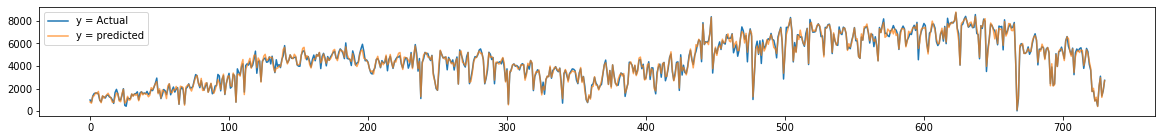

In [24]:
plt.figure(figsize=(20,2))
plt.plot(reg_y_df.values)
plt.plot(reg_predictions, alpha=0.7)
plt.legend(['y = Actual', 'y = predicted'], loc='upper left')
plt.show()

### Classification

In [25]:
gbc = GradientBoostClassifier()

In [26]:
gbc.fit(clf_X_df.values, clf_y_df.values, n_estimators=25, max_depth=10, max_leaves_count=20, min_samples=50, learning_rate=0.8)

Progress: 33.33333333333333%
Progress: 66.66666666666666%
Progress: 100.0%


In [27]:
clf_predictions = gbc.predict(clf_X_df.values)

In [28]:
def accuracy_classification(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

#### Classification training score

In [29]:
accuracy_classification(clf_y_df.values, clf_predictions)

0.98